LEVEL 1 OF DATA CLEANING (REMOVING DUPLICATES AND NULL VALUES)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [75]:
df = pd.read_csv("Dataset.csv")

In [77]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    12575 non-null  object 
 1   Customer ID       12575 non-null  object 
 2   Category          12575 non-null  object 
 3   Item              11362 non-null  object 
 4   Price Per Unit    11966 non-null  float64
 5   Quantity          11971 non-null  float64
 6   Total Spent       11971 non-null  float64
 7   Payment Method    12575 non-null  object 
 8   Location          12575 non-null  object 
 9   Transaction Date  12575 non-null  object 
 10  Discount Applied  8376 non-null   object 
dtypes: float64(3), object(8)
memory usage: 1.1+ MB


,0
Transaction ID,0
Customer ID,0
Category,0
Item,1213
Price Per Unit,609
Quantity,604
Total Spent,604
Payment Method,0
Location,0
Transaction Date,0


Removal of Duplicate Rows

In [78]:
df=df.drop_duplicates()

Removal of Null Values in "Quantity" column and "Item" column

In [79]:
new_Quantity=df['Quantity'].median()
df['Quantity'] = df['Quantity'].fillna(new_Quantity)
df['Item'] = df['Item'].fillna('Unknown')


Removal of Null Values in "Price Per Unit" column

In [80]:
mask = (
    df['Price Per Unit'].isna() &
    df['Total Spent'].notna() &
    df['Quantity'].notna()
)

df.loc[mask, 'Price Per Unit'] = (
    df.loc[mask, 'Total Spent'] / df.loc[mask, 'Quantity']
)


Removal of Null Values in "Total Spent" column

In [81]:
mask = (
    df['Total Spent'].isna() &
    df['Price Per Unit'].notna() &
    df['Quantity'].notna()
)

df.loc[mask, 'Total Spent'] = (
    df.loc[mask, 'Price Per Unit'] * df.loc[mask, 'Quantity']
)


Cleaning the values of "Payment Method" column

In [82]:
df['Payment Method'] = (
    df['Payment Method']
    .str.strip()
    .str.title()
)

Creating "Transaction Month" column for analysing Monthly trends

In [83]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
df['Transaction Month'] = df['Transaction Date'].dt.month_name()
df['Transaction Month'] = pd.Categorical(
    df['Transaction Month'],
    categories=month_order,
    ordered=True
)

Removing Null Values of "Discount Applied" colum

In [84]:
df['Discount Applied'] = df['Discount Applied'].astype('object')
df['Discount Applied'] = df['Discount Applied'].fillna('Unknown')

In [85]:
df.isnull().sum()

,0
Transaction ID,0
Customer ID,0
Category,0
Item,0
Price Per Unit,0
Quantity,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


EXPLORATORY DATA ANALYSIS

1. Sales trends over time

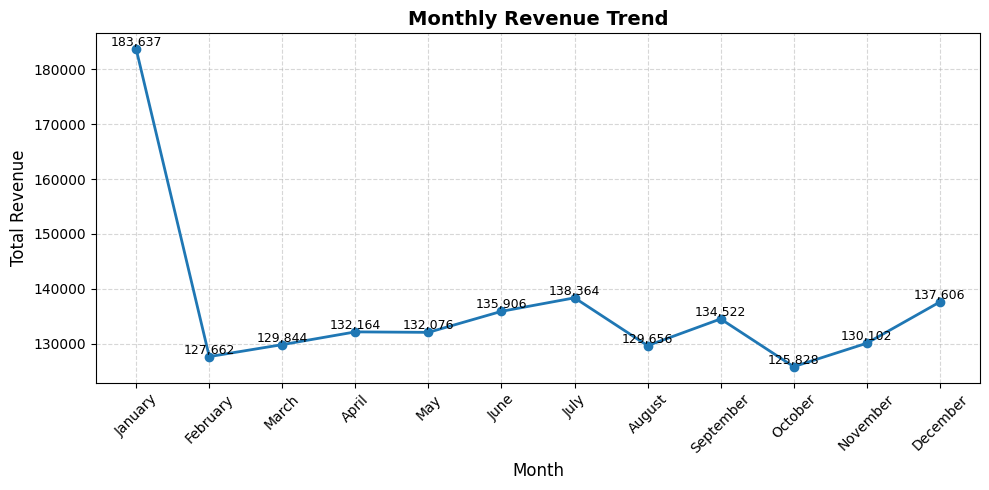

In [86]:
monthly_sales = (
    df.groupby('Transaction Month', observed=False)['Total Spent']
      .sum()
      .reindex(month_order, fill_value=0)
)
plt.figure(figsize=(10, 5))
plt.plot(
    monthly_sales.index,
    monthly_sales.values,
    marker='o',
    linewidth=2,
    color='tab:blue'
)
plt.title("Monthly Revenue Trend", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
for i, value in enumerate(monthly_sales.values):
    plt.text(
        i,
        value,
        f"{value:,.0f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. Top product categories

/tmp/ipython-input-2040666519.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


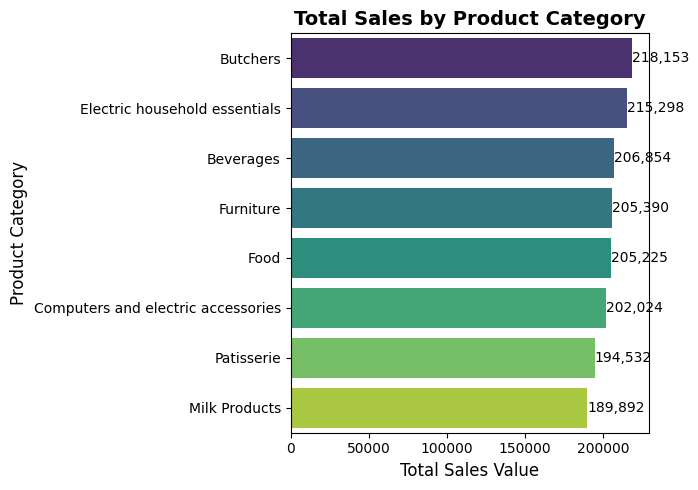

In [87]:

category_sales = (
    df.groupby('Category')['Total Spent']
    .sum()
    .sort_values(ascending=False)
)
plt.figure(figsize=(7, 5))
sns.barplot(
    x=category_sales.values,
    y=category_sales.index,
    palette="viridis"
)
plt.title("Total Sales by Product Category", fontsize=14, weight='bold')
plt.xlabel("Total Sales Value", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
for i, value in enumerate(category_sales.values):
    plt.text(value, i, f"{value:,.0f}", va='center')

plt.tight_layout()
plt.show()



3. Payment method distribution

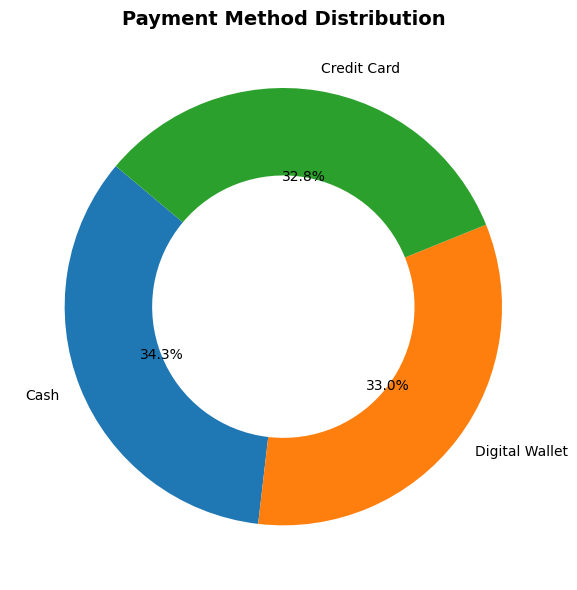

In [88]:
payment_counts = df['Payment Method'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    payment_counts.values,
    labels=payment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'width': 0.4}
)

plt.title("Payment Method Distribution", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


4. Location-wise sales performance

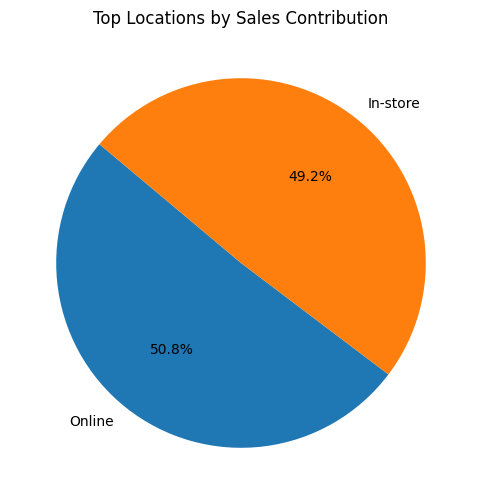

In [89]:
top_locations = location_sales.sort_values(ascending=False).head(5)

plt.figure(figsize=(6, 6))
plt.pie(
    top_locations.values,
    labels=top_locations.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Top Locations by Sales Contribution")
plt.show()


5. Items with highest/lowest average sales

/tmp/ipython-input-382764057.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


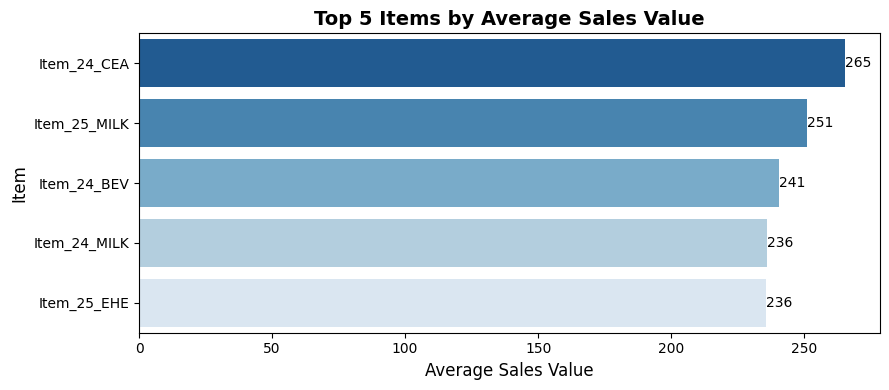

/tmp/ipython-input-382764057.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


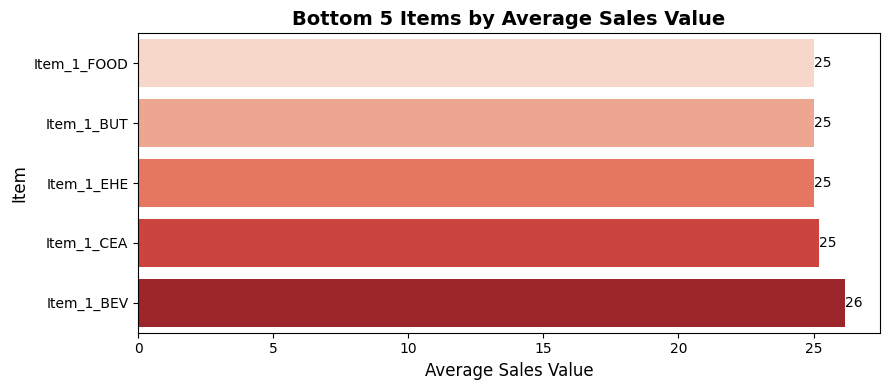

In [90]:
item_avg_sales = df.groupby('Item')['Total Spent'].mean()
item_avg_sales_filtered = item_avg_sales.drop('Unknown', errors='ignore')

top_items = item_avg_sales_filtered.sort_values(ascending=False).head(5)
bottom_items = item_avg_sales_filtered.sort_values().head(5)

plt.figure(figsize=(9, 4))
sns.barplot(
    x=top_items.values,
    y=top_items.index,
    palette='Blues_r'
)
plt.title("Top 5 Items by Average Sales Value", fontsize=14, weight='bold')
plt.xlabel("Average Sales Value", fontsize=12)
plt.ylabel("Item", fontsize=12)

for i, value in enumerate(top_items.values):
    plt.text(value, i, f"{value:,.0f}", va='center')

plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
sns.barplot(
    x=bottom_items.values,
    y=bottom_items.index,
    palette='Reds'
)
plt.title("Bottom 5 Items by Average Sales Value", fontsize=14, weight='bold')
plt.xlabel("Average Sales Value", fontsize=12)
plt.ylabel("Item", fontsize=12)

for i, value in enumerate(bottom_items.values):
    plt.text(value, i, f"{value:,.0f}", va='center')

plt.tight_layout()
plt.show()


6. Correlation analysis

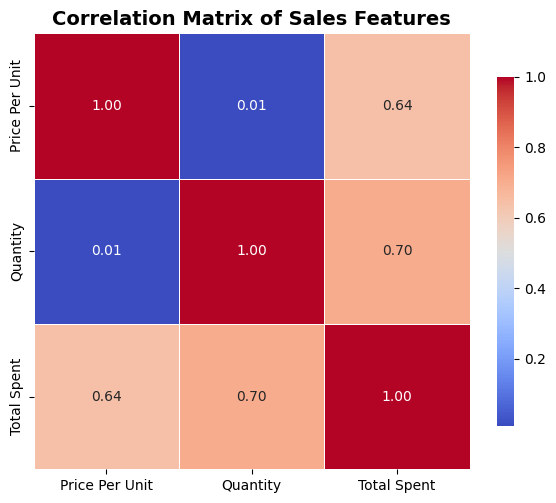

In [91]:
corr_matrix = df[['Price Per Unit', 'Quantity', 'Total Spent']].corr()

plt.figure(figsize=(6, 5))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix of Sales Features", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
